# Fine Tuning Tiny Yolo

The Tiny Yolo Network is fine tuned to only detect people.

## Prepare Workspace

### Define GOOGLE COLAB Flag

In [1]:
GOOGLE_COLAB = True

### Mount Google Drive

In [ ]:
if GOOGLE_COLAB:
    import os
    from google.colab import drive

    # Check if Google Drive is already mounted
    if not os.path.exists('/content/drive/My Drive'):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
    else:
        print("Google Drive is already mounted.")

### Set-up Directories & Install Libraires
Create the directories needed and copy uploaded files into them

In [ ]:
if GOOGLE_COLAB:
    try:
        installed
        print("Libraires already installed.")
    except NameError:
        print("Installing libraires...")
        !pip install torchinfo
        !pip install torchvision pillow

        !mkdir /content/data

        !cp /content/drive/MyDrive/eml_challenge/data/person_indices.json /content/data
        !cp -r /content/drive/MyDrive/eml_challenge/utils /content
        !cp /content/drive/MyDrive/eml_challenge/tinyyolov2.py /content
        installed = True

### Define Path to Weights

In [4]:
if GOOGLE_COLAB:
    WEIGHTS_PATH = "/content/drive/MyDrive/eml_challenge/weights/"
else:
    WEIGHTS_PATH = "./"

### Append Directory Paths to System Path

In [5]:
import sys
if GOOGLE_COLAB:
    sys.path.append('/content')
    sys.path.append('/content/data')
    sys.path.append('/content/utils')
    sys.path.append(WEIGHTS_PATH)

### Import Libraries

In [6]:
# Pytorch libraries
import torch
import torchinfo
import torch.nn as nn
from torch.utils.data import Subset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import ReduceLROnPlateau to reduce learning rate of optimizer after Plateau

# Scikit-learn libraires
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Other libraires
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# EML libraires
from tinyyolov2 import TinyYoloV2
from utils.loss import YoloLoss
from utils.dataloader_v2 import VOCDataset
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes
from utils.viz import display_result

## Define Functions

### Define split_dataset_custom Function

In [7]:
def split_dataset_custom(dataset: torch.utils.data.Dataset, train_ratio: float, test_ratio: float, validation_ratio: float, pipeline=None):
    if (train_ratio + validation_ratio + test_ratio != 1):
        raise ValueError("The sum of the ratios must be equal to 1.")

    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    # Step 2: Split into train+validation and test
    train_validation_indices, test_indices = train_test_split(indices, test_size=int(test_ratio*dataset_size), random_state=42)
    # Step 3: Split train+validation into train and val
    train_indices, validation_indices = train_test_split(train_validation_indices, test_size=int(validation_ratio*dataset_size), random_state=42)

    # Create Subsets
    train_dataset = Subset(dataset, train_indices)
    validation_dataset = Subset(dataset, validation_indices)
    test_dataset = Subset(dataset, test_indices)

    if pipeline:
        train_dataset.transform = pipeline

    return train_dataset, validation_dataset, test_dataset

### Define split_dataset_kfolds Function

In [8]:
def split_dataset_kfolds(dataset: torch.utils.data.Dataset, train_indices, validation_indices, pipeline):
    train_dataset = Subset(dataset, train_indices)
    validation_dataset = Subset(dataset, validation_indices)

    if pipeline:
        train_dataset.transform = pipeline

    return train_dataset, validation_dataset

### Define Early Stopping Class

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0,
                 path='/content/drive/MyDrive/eml_challenge/weights/checkpoint.pt',
                 best_model_path='/content/drive/MyDrive/eml_challenge/weights/voc_fine_tuned.pt'):
        """
        Args:
            patience (int): How long to wait after last improvement.
            verbose (bool): If True, prints a message for each validation metric improvement.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
            path (str): Path to save the best model checkpoint.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.best_model_path = best_model_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.avg_precision_min = 0 # Track the minimum average precision

    def __call__(self, avg_precision, model):
        score = avg_precision  # Positive because we maximize AP

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(avg_precision, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                torch.save(model.state_dict(), self.best_model_path)
        else:
            self.best_score = score
            self.save_checkpoint(avg_precision, model)
            self.counter = 0

    def save_checkpoint(self, avg_precision, model):
        """Save model when average precision increases."""
        if self.verbose:
            print(f"Average Precision increased ({self.avg_precision_min:.6f} --> {avg_precision:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.avg_precision_min = avg_precision


### Define train, validate and test Functions

In [10]:
def train(net: nn.Module, data_loader: torch.utils.data.DataLoader, optimizer, criterion, device):
    """
    Description:
    This function trains the network for one epoch and returns average loss.

    Args:
    net: the network to train
    data_loader: the data loader for the training set
    optimizer: the optimizer to use for training
    criterion: the loss function to use for training
    device: the device to use for training
    """

    total_loss = 0

    net.train()
    # Move weights to device
    net.to(device)

    for idx, (input, target) in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
        # Move Inputs and targets to Device
        input  = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        #Yolo head is implemented in the loss for training, therefore yolo=False
        output = net(input, yolo=False)
        loss, _ = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)

    return average_loss

def validate(net: nn.Module, data_loader: torch.utils.data.DataLoader, device):
    """
    Description:
    This function is used to validate the network. It is currently needed for
    early stopping and learning rate adjustment.

    Args:
    net: the network to test
    data_loader: the data loader for the test set
    device: the device to use for training
    """

    eval_precision = []
    eval_recall = []

    net.eval()
    # Move weights to device
    net.to(device)

    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
            input  = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, CONFIDENCE_THRESHOLD)
            output = nms(output, NMS_THRESHOLD)
            # Calculate precision and recall for each sample
            for i in range(len(target)):
                precision, recall = precision_recall_levels(target[i], output[i])
                eval_precision.append(precision)
                eval_recall.append(recall)

    # Calculate average precision with collected samples
    average_precision = ap(eval_precision, eval_recall)
    # Plot ROC
    display_roc(eval_precision, eval_recall)

    return average_precision


def test(net: nn.Module, data_loader: torch.utils.data.DataLoader, device, best_model_path):
    """
    Description:
    This function tests the network.

    Args:
    net: the network to test
    data_loader: the data loader for the test set
    device: the device to use for training
    num_validation_samples: the number of passed images to the validate function
    """

    test_precision = []
    test_recall = []

    # Load weights and move them to device
    sd = torch.load(best_model_path, weights_only=True)
    net.load_state_dict(sd)
    net.to(device)
    net.eval()

    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
            input  = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, CONFIDENCE_THRESHOLD)
            output = nms(output, NMS_THRESHOLD)
            # Calculate precision and recall for each sample
            for i in range(len(target)):
                precision, recall = precision_recall_levels(target[i], output[i])
                test_precision.append(precision)
                test_recall.append(recall)

    # Calculate average precision with collected samples
    average_precision = ap(test_precision, test_recall)
    # Plot ROC
    display_roc(test_precision, test_recall)

    return average_precision


### Define plot_loss Function

In [11]:
def plot_loss(losses):
    """
    Plots the losses over epochs.

    Args:
        losses (list of float): List of loss values, one for each epoch.
    """
    epochs = range(1, len(losses) + 1)  # Epoch numbers start at 1
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, marker='o', label='Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Define fine_tune Function

In [12]:
def fine_tune(net: nn.Module,
              sd,
              data_loader: torch.utils.data.DataLoader,
              validation_loader: torch.utils.data.DataLoader,
              test_loader: torch.utils.data.DataLoader):

    if torch.cuda.is_available():
      torch_device = torch.device("cuda")
      print("Using GPU")
    else:
      torch_device = torch.device("cpu")
      print("Using CPU")

    eval_AP = []
    epoch_loss_list = []

    #We load all parameters from the pretrained dict except for the last layer
    net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)

    #We only train the last layer (conv9)
    for key, param in net.named_parameters():
        if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
            param.requires_grad = False

    # Definition of the loss
    criterion = YoloLoss(anchors=net.anchors)

    # Definition of the optimizer
    learning_rate = 0.001
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=learning_rate)

    # Define the ReduceLROnPlateau scheduler
    if ADJUST_LEARNING_RATE:
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    # Initialize EarlyStopping
    if EARLY_STOPPING:
        early_stopping = EarlyStopping(patience=5, verbose=True, path=WEIGHTS_PATH+"checkpoint.pt", best_model_path=TRAINED_WEIGHTS_PATH)

    for epoch in range(NUM_EPOCHS):
        print("****************************************************************************************************************************")
        print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

        # Train the network
        average_loss = train(net, data_loader, optimizer, criterion, torch_device)
        epoch_loss_list.append(average_loss)

        # Validate the network
        average_precision = validate(net, validation_loader, torch_device)
        eval_AP.append(average_precision)
        print(f'Average Precision in the last 5 Epochs: {eval_AP[-5:]}')
        print(f'Average Precision This Epoch: {average_precision:.3%}')
        # Adjust learning rate in case of a Plateau of AP
        if ADJUST_LEARNING_RATE:
            scheduler.step(average_precision)
            print(f"Learning Rate: {scheduler.get_last_lr()}")
        # Stop training in case there is no further improvement of AP
        if EARLY_STOPPING:
            early_stopping(average_precision, net)
            if early_stopping.early_stop:
                print("Early stopping triggered. Stopping training.")
                break

    if EARLY_STOPPING:
        if not early_stopping.early_stop:
            torch.save(net.state_dict(), WEIGHTS_PATH + "voc_fine_tuned.pt")
            print("No early stopping triggered. Training completed.")

    best_validation_average_precision = max(eval_AP)
    # Test the network
    test_average_precision = test(net, test_loader, torch_device, best_model_path=TRAINED_WEIGHTS_PATH)
    print(f'Best Validation Average Precision: {best_validation_average_precision:.3%}')
    print(f'Test Average Precision:            {test_average_precision:.3%}')
    print("****************************************************************************************************************************")

    # Plot the loss curve
    plot_loss(epoch_loss_list)

    # torch.cuda.empty_cache()

    return best_validation_average_precision, test_average_precision

## Execute Workspace

### Define data augmentation pipeline

In [13]:
pipeline = v2.Compose([
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(p=0.5),
    v2.ColorJitter(),
])

### Define Hyperparameters

In [14]:
# Number or Epochs for fine-tuning
NUM_EPOCHS               = 30
# Thresholds
CONFIDENCE_THRESHOLD     = 0.0
NMS_THRESHOLD            = 0.5
# Batch sizes
TRAIN_BATCH_SIZE         = 64
VALIDATION_BATCH_SIZE    = 32
TEST_BATCH_SIZE          = 1

### Define Flags

In [43]:
# Flags
ADJUST_LEARNING_RATE     = False
EARLY_STOPPING           = True
K_FOLDS                  = False
CUSTOM_SPLIT             = False
DISCONNECT_RUNTIME       = False
# Dataset custom split ratios
if CUSTOM_SPLIT:
    TRAIN_DATASET_RATIO      = 0.70
    TEST_DATASET_RATIO       = 0.20
    VALIDATION_DATASET_RATIO = 0.10
# K-Folds
elif K_FOLDS:
    NUMBER_OF_FOLDS          = 4
else:
    VALIDATION_DATASET_RATIO = 0.10

### Define Constants

In [44]:
VOC_DATASET_PATH     = "/content/drive/MyDrive/eml_challenge/data/VOC"
TRAINED_WEIGHTS_PATH = WEIGHTS_PATH+"voc_fine_tuned_test.pt"

### Define Datasets and Data Loaders

In [ ]:
if CUSTOM_SPLIT:
    dataset = VOCDataset(root=VOC_DATASET_PATH, year="2012", image_set='trainval', transform=None, only_person=True) # Contains 4374 pictures

    train_dataset, validation_dataset, test_dataset = split_dataset_custom(dataset,
                                                                           train_ratio=TRAIN_DATASET_RATIO,
                                                                           test_ratio=TEST_DATASET_RATIO,
                                                                           validation_ratio=VALIDATION_DATASET_RATIO,
                                                                           pipeline=pipeline)

    train_loader      = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)
    test_loader       = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

else:
    train_dataset = VOCDataset(root=VOC_DATASET_PATH, year="2012", image_set='train', transform=pipeline, only_person=True) # Contains 2142 pictures
    test_dataset  = VOCDataset(root=VOC_DATASET_PATH, year="2012", image_set='val', only_person=True)   # Contains 2232 pictures

    if K_FOLDS:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    else:
        test_dataset_size  = len(test_dataset)
        test_indices       = list(range(test_dataset_size))
        test_indices, validation_indices = train_test_split(test_indices, test_size=int(VALIDATION_DATASET_RATIO*test_dataset_size), random_state=42)

        validation_dataset = Subset(test_dataset, validation_indices)
        test_dataset       = Subset(test_dataset, test_indices)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

### Fine-tune the Network

Using GPU
****************************************************************************************************************************
Epoch: 1/30


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 7/7 [00:42<00:00,  6.08s/it]


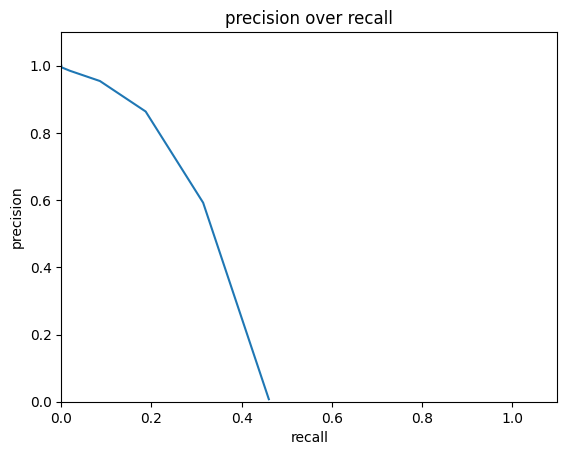

Average Precision in the last 5 Epochs: [0.2778072481142781]
Average Precision This Epoch: 27.781%
Average Precision increased (0.000000 --> 0.277807). Saving model...
****************************************************************************************************************************
Epoch: 2/30


100%|██████████| 7/7 [00:43<00:00,  6.19s/it]


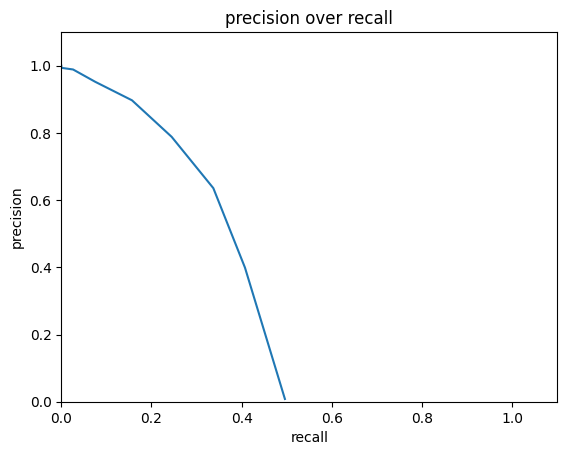

Average Precision in the last 5 Epochs: [0.2778072481142781, 0.3381904147479313]
Average Precision This Epoch: 33.819%
Average Precision increased (0.277807 --> 0.338190). Saving model...
****************************************************************************************************************************
Epoch: 3/30


100%|██████████| 7/7 [00:43<00:00,  6.28s/it]


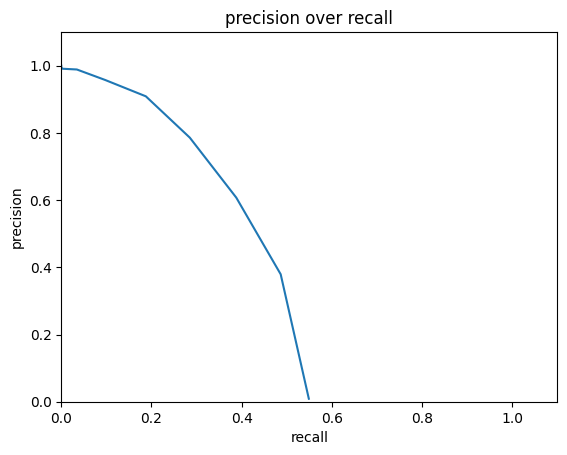

Average Precision in the last 5 Epochs: [0.2778072481142781, 0.3381904147479313, 0.33551545440205943]
Average Precision This Epoch: 33.552%
EarlyStopping counter: 1 out of 5
****************************************************************************************************************************
Epoch: 4/30


100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


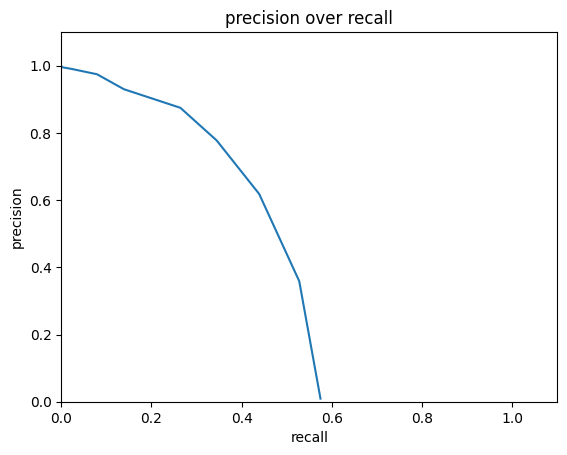

Average Precision in the last 5 Epochs: [0.2778072481142781, 0.3381904147479313, 0.33551545440205943, 0.41448026590931925]
Average Precision This Epoch: 41.448%
Average Precision increased (0.338190 --> 0.414480). Saving model...
****************************************************************************************************************************
Epoch: 5/30


100%|██████████| 7/7 [00:44<00:00,  6.30s/it]


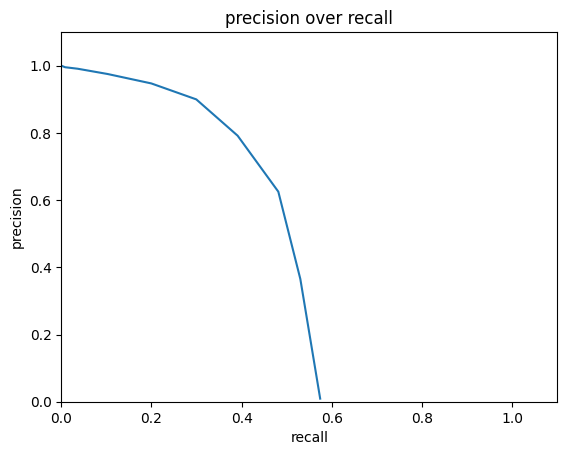

Average Precision in the last 5 Epochs: [0.2778072481142781, 0.3381904147479313, 0.33551545440205943, 0.41448026590931925, 0.4234017943422867]
Average Precision This Epoch: 42.340%
Average Precision increased (0.414480 --> 0.423402). Saving model...
****************************************************************************************************************************
Epoch: 6/30


100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


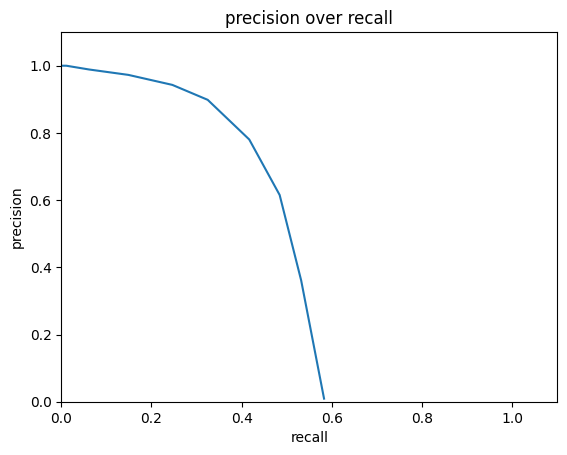

Average Precision in the last 5 Epochs: [0.3381904147479313, 0.33551545440205943, 0.41448026590931925, 0.4234017943422867, 0.4505371522254116]
Average Precision This Epoch: 45.054%
Average Precision increased (0.423402 --> 0.450537). Saving model...
****************************************************************************************************************************
Epoch: 7/30


100%|██████████| 7/7 [00:48<00:00,  6.90s/it]


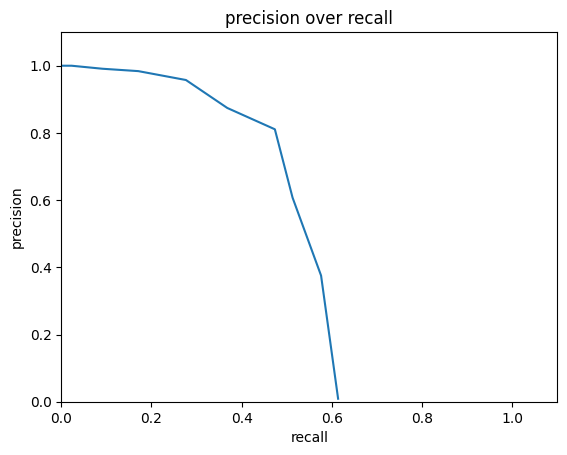

Average Precision in the last 5 Epochs: [0.33551545440205943, 0.41448026590931925, 0.4234017943422867, 0.4505371522254116, 0.4766119997083544]
Average Precision This Epoch: 47.661%
Average Precision increased (0.450537 --> 0.476612). Saving model...
****************************************************************************************************************************
Epoch: 8/30


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


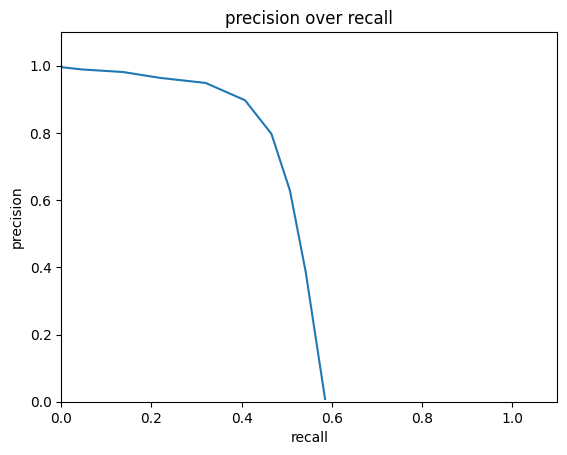

Average Precision in the last 5 Epochs: [0.41448026590931925, 0.4234017943422867, 0.4505371522254116, 0.4766119997083544, 0.4926659663206748]
Average Precision This Epoch: 49.267%
Average Precision increased (0.476612 --> 0.492666). Saving model...
****************************************************************************************************************************
Epoch: 9/30


100%|██████████| 7/7 [00:52<00:00,  7.51s/it]


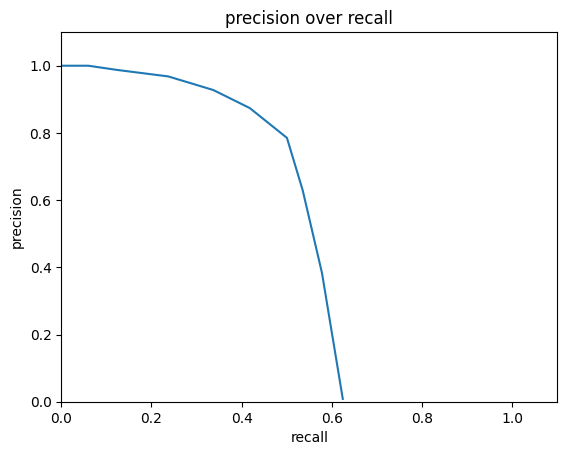

Average Precision in the last 5 Epochs: [0.4234017943422867, 0.4505371522254116, 0.4766119997083544, 0.4926659663206748, 0.5046385406957092]
Average Precision This Epoch: 50.464%
Average Precision increased (0.492666 --> 0.504639). Saving model...
****************************************************************************************************************************
Epoch: 10/30


100%|██████████| 7/7 [00:53<00:00,  7.61s/it]


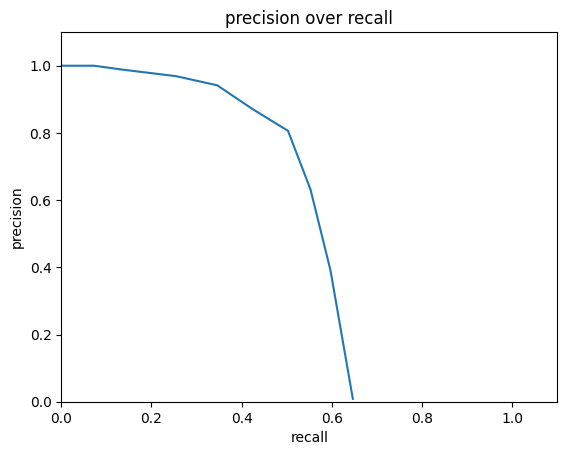

Average Precision in the last 5 Epochs: [0.4505371522254116, 0.4766119997083544, 0.4926659663206748, 0.5046385406957092, 0.5076605601339182]
Average Precision This Epoch: 50.766%
Average Precision increased (0.504639 --> 0.507661). Saving model...
****************************************************************************************************************************
Epoch: 11/30


100%|██████████| 7/7 [00:53<00:00,  7.63s/it]


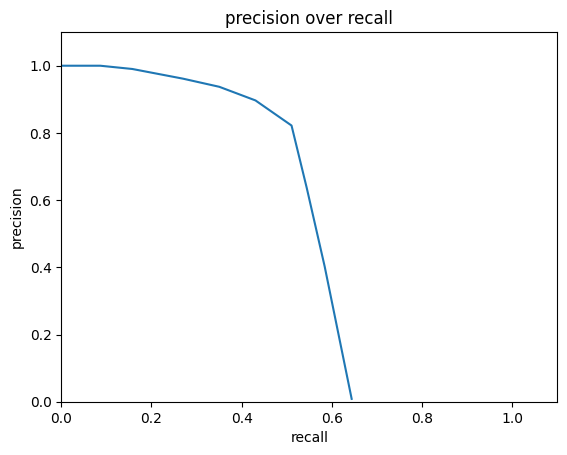

Average Precision in the last 5 Epochs: [0.4766119997083544, 0.4926659663206748, 0.5046385406957092, 0.5076605601339182, 0.5105682797202792]
Average Precision This Epoch: 51.057%
Average Precision increased (0.507661 --> 0.510568). Saving model...
****************************************************************************************************************************
Epoch: 12/30


100%|██████████| 7/7 [00:54<00:00,  7.72s/it]


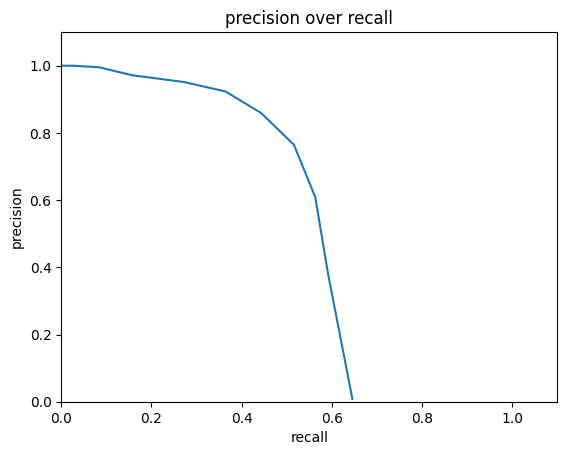

Average Precision in the last 5 Epochs: [0.4926659663206748, 0.5046385406957092, 0.5076605601339182, 0.5105682797202792, 0.4980877378763484]
Average Precision This Epoch: 49.809%
EarlyStopping counter: 1 out of 5
****************************************************************************************************************************
Epoch: 13/30


100%|██████████| 7/7 [00:53<00:00,  7.61s/it]


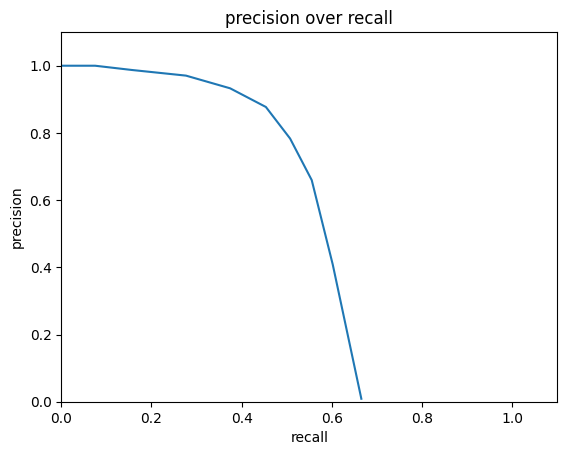

Average Precision in the last 5 Epochs: [0.5046385406957092, 0.5076605601339182, 0.5105682797202792, 0.4980877378763484, 0.5417932249065707]
Average Precision This Epoch: 54.179%
Average Precision increased (0.510568 --> 0.541793). Saving model...
****************************************************************************************************************************
Epoch: 14/30


100%|██████████| 7/7 [00:53<00:00,  7.68s/it]


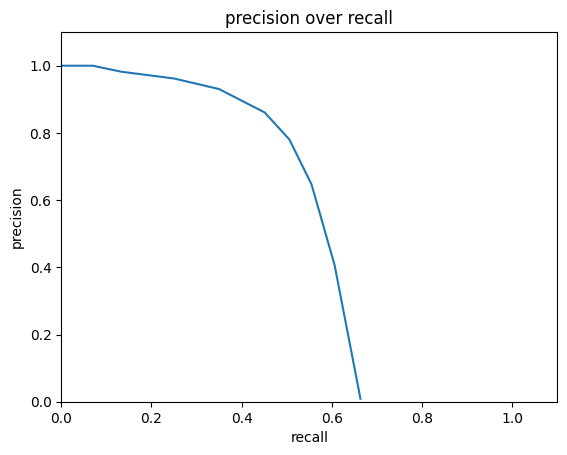

Average Precision in the last 5 Epochs: [0.5076605601339182, 0.5105682797202792, 0.4980877378763484, 0.5417932249065707, 0.5383814614616539]
Average Precision This Epoch: 53.838%
EarlyStopping counter: 1 out of 5
****************************************************************************************************************************
Epoch: 15/30


100%|██████████| 7/7 [00:54<00:00,  7.83s/it]


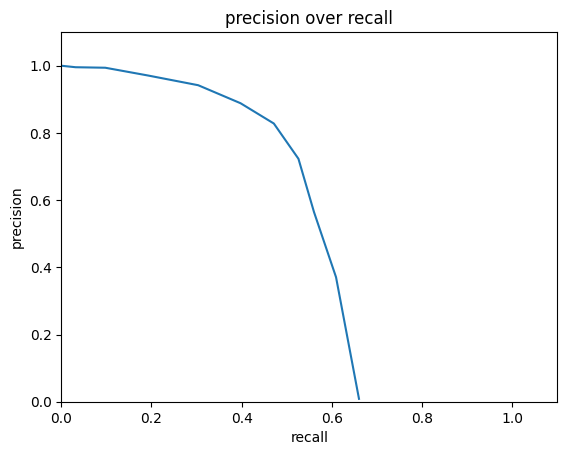

Average Precision in the last 5 Epochs: [0.5105682797202792, 0.4980877378763484, 0.5417932249065707, 0.5383814614616539, 0.5251476927525274]
Average Precision This Epoch: 52.515%
EarlyStopping counter: 2 out of 5
****************************************************************************************************************************
Epoch: 16/30


100%|██████████| 7/7 [00:52<00:00,  7.54s/it]


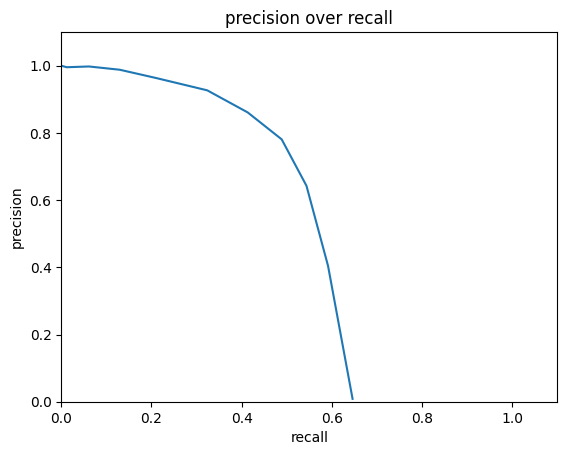

Average Precision in the last 5 Epochs: [0.4980877378763484, 0.5417932249065707, 0.5383814614616539, 0.5251476927525274, 0.490040105772016]
Average Precision This Epoch: 49.004%
EarlyStopping counter: 3 out of 5
****************************************************************************************************************************
Epoch: 17/30


100%|██████████| 7/7 [00:54<00:00,  7.75s/it]


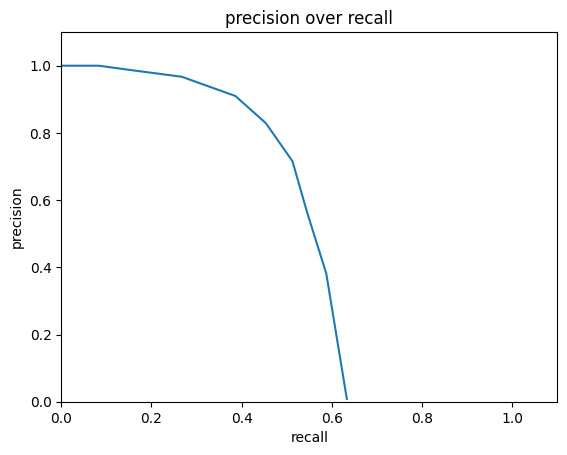

Average Precision in the last 5 Epochs: [0.5417932249065707, 0.5383814614616539, 0.5251476927525274, 0.490040105772016, 0.49242402640982835]
Average Precision This Epoch: 49.242%
EarlyStopping counter: 4 out of 5
****************************************************************************************************************************
Epoch: 18/30


100%|██████████| 7/7 [00:54<00:00,  7.79s/it]


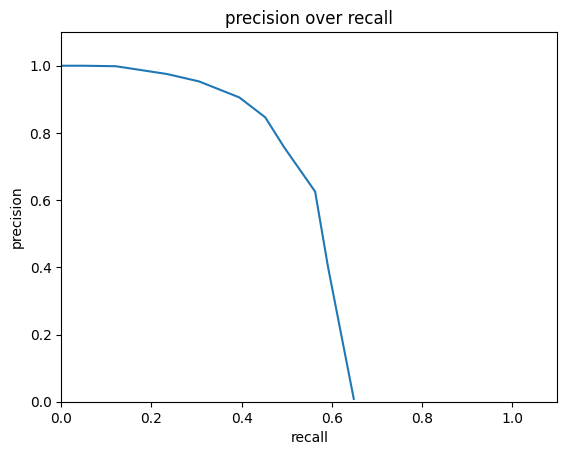

Average Precision in the last 5 Epochs: [0.5383814614616539, 0.5251476927525274, 0.490040105772016, 0.49242402640982835, 0.4915991260774977]
Average Precision This Epoch: 49.160%
EarlyStopping counter: 5 out of 5
Early stopping triggered. Stopping training.


100%|██████████| 2009/2009 [07:51<00:00,  4.26it/s]


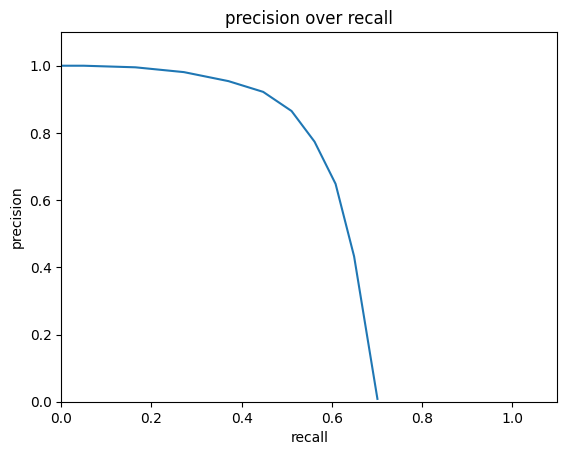

Best Validation Average Precision: 54.179%
Test Average Precision:            57.952%
****************************************************************************************************************************


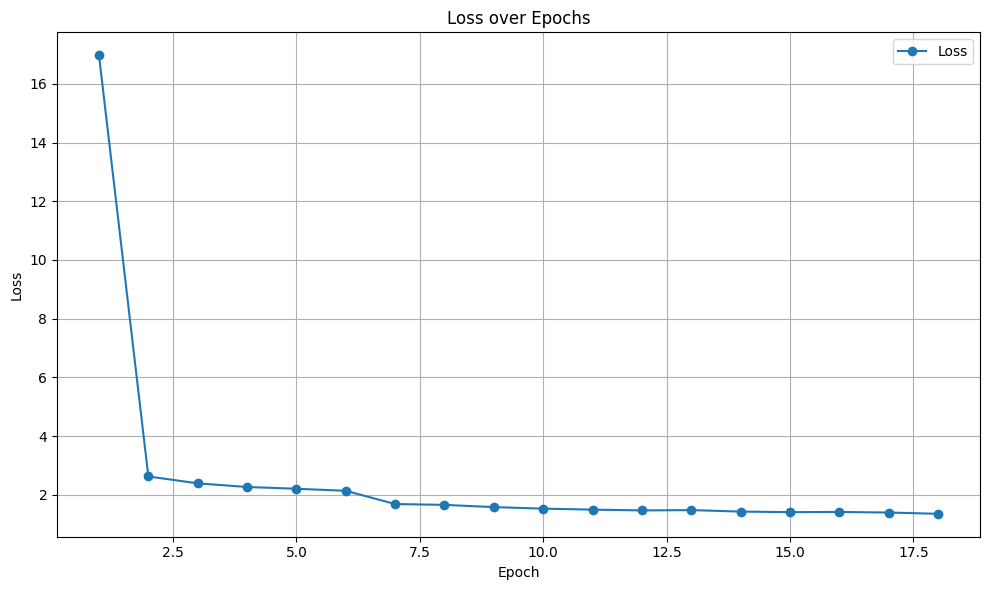

In [18]:
# We define a tinyyolo network with only two possible classes
net = TinyYoloV2(num_classes=1)

sd = torch.load(WEIGHTS_PATH + "voc_pretrained.pt", weights_only=True)

if K_FOLDS:
    kf = KFold(n_splits=NUMBER_OF_FOLDS, shuffle=True, random_state=42)

    fold_validation_average_precisions = []
    fold_test_average_precisions       = []

    for fold, (test_indices, validation_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{NUMBER_OF_FOLDS}")

        # Create subsets for training and validation
        test_subset, validation_subset = split_dataset_kfolds(dataset=test_dataset,
                                                               train_indices=test_indices,
                                                               validation_indices=validation_indices,
                                                               pipeline=None)

        test_loader       = torch.utils.data.DataLoader(dataset=test_subset, batch_size=TEST_BATCH_SIZE, shuffle=True)
        validation_loader = torch.utils.data.DataLoader(dataset=validation_subset, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)

        # Fine-tune the network
        fold_validation_average_precision, fold_test_average_precision = fine_tune(net, sd, train_loader, validation_loader, test_loader)

        fold_validation_average_precisions.append(fold_validation_average_precision)
        fold_test_average_precisions.append(fold_test_average_precision)

    # Calculate the mean average precision across folds
    mean_average_precision = sum(fold_test_average_precisions) / NUMBER_OF_FOLDS

    print(f"Validation Average Precisions across {NUMBER_OF_FOLDS} folds: {fold_validation_average_precisions}")
    print(f"Test Average Precisions across {NUMBER_OF_FOLDS} folds: {fold_test_average_precisions}")
    print(f"Mean Average Precision across {NUMBER_OF_FOLDS} folds: {mean_average_precision}")
else:
    # Fine-tune the network
    fine_tune(net, sd, train_loader, validation_loader, test_loader)

### Disconnect runtime

In [19]:
if GOOGLE_COLAB and DISCONNECT_RUNTIME:
    from google.colab import runtime
    runtime.unassign()